In [47]:
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionUpscalePipeline, DiffusionPipeline, StableDiffusionDepth2ImgPipeline, DPMSolverMultistepScheduler
from diffusers import StableDiffusionImageVariationPipeline

import torch
from PIL import Image
import random
import cv2
import matplotlib.pyplot as plt

In [49]:
state = None
current_steps = 25
attn_slicing_enabled = True
#mem_eff_attn_enabled = install_xformers
scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionImageVariationPipeline.from_pretrained(
      "lambdalabs/sd-image-variations-diffusers", revision="v2.0"
    ).to("cuda")
pipe.enable_attention_slicing()

C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
vae\diffusion_pytorch_model.safetensors not found
Fetching 11 files:   0%|                                                                

In [56]:
img1=cv2.imread('../data/originalpng/1f32b.png')
img2=cv2.imread('../data/originalpng/u1f004.png')
imgtorch1=torch.tensor(img1).cuda().permute(2,0,1).unsqueeze(0).flip(1)
imgtorch2=torch.tensor(img2).cuda().permute(2,0,1).unsqueeze(0).flip(1)
imgtorch1=torch.nn.functional.interpolate(imgtorch1,(224,224))
imgtorch2=torch.nn.functional.interpolate(imgtorch2,(224,224))

In [57]:
pipe.image_encoder(imgtorch1)[0].shape

torch.Size([1, 768])

In [59]:
pipe.scheduler.set_timesteps(num_inference_steps, device=device)
timesteps = pipe.scheduler.timesteps

StableDiffusionImageVariationPipeline {
  "_class_name": "StableDiffusionImageVariationPipeline",
  "_diffusers_version": "0.21.1",
  "_name_or_path": "lambdalabs/sd-image-variations-diffusers",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    "transformers",
    "CLIPVisionModelWithProjection"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [37]:
tokens=pipe.tokenizer('beautiful sunset',return_tensors="pt")
embeds=pipe.text_encoder(tokens['input_ids'].cuda(),attention_mask=tokens['attention_mask'].cuda())[0]
negembeds=None


In [46]:
embeds[0]

tensor([[[-0.3135, -0.4478, -0.0082,  ...,  0.2544, -0.0327, -0.2959],
         [ 0.2832, -1.5430,  0.6777,  ...,  0.8750,  0.9004,  1.7402],
         [-0.4324,  0.3738, -0.6855,  ..., -0.2113,  0.9180, -2.0156],
         [-0.9873, -0.2590, -1.9844,  ...,  1.9209,  0.0342,  1.7129]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<NativeLayerNormBackward0>)

In [19]:
with torch.no_grad():
    enc1=vae.encode(imgtorch1.half()/255).latent_dist
    enc2=vae.encode(imgtorch2.half()/255).latent_dist
    #enc=enc1+enc2
    sample=enc1.mode()/2+enc2.mode()/2
    dec=vae.decode(sample).sample
    imgdec=dec[0].permute(1,2,0).detach().cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


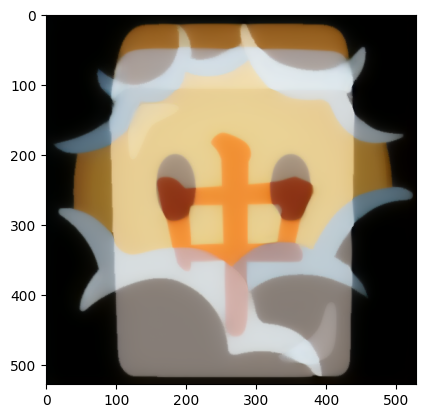

In [20]:
plt.imshow(imgdec.astype(float))